# PyTorch Experiment Tracking

In [1]:
try:
    import torch
    import torchvision
    assert(int(torch.__version__.split('.')[0]) >= 2 or int(torch.__version__.split(".")[1]) >= 12, "torch version must be greater than 1.12")
    assert(int(torchvision.__version__.split(".")[1]) >= 13, "torch version must be greater than 0.13")
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

<>:4: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:5: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:4: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:5: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/tmp/ipykernel_4802/2401564698.py:4: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(int(torch.__version__.split('.')[0]) >= 2 or int(torch.__version__.split(".")[1]) >= 12, "torch version must be greater than 1.12")
/tmp/ipykernel_4802/2401564698.py:5: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(int(torchvision.__version__.split(".")[1]) >= 13, "torch version must be greater than 0.13")


torch version: 2.1.1+cu121
torchvision version: 0.16.1+cu121


In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn 
from torchvision import transforms

from torchinfo import summary
from modular_version import data_setup, engine

/home/umer/umer_projects/torch_tutor/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Setiing up the device agnostic code

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Create a helper function to set seeds

In [4]:
def set_seeds(seed: int=42):
    """Sets random seeds for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

### Get Data

In [5]:
import os
import zipfile

from pathlib import Path
import requests

def download_data(source: str,
                  destination: str,
                  remove_source: bool=True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.
    
    Returns:
        pathlib.Path to downloaded data.
    
    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """

    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download and prepare it...
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)

        # Download Pizza, Steak and Sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak and sushi
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...")
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

### Create Datasets and DataLoaders
#### Create DataLoaders using Manually Created Transforms

In [6]:
# Setup directories
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup ImageNet normalization levels (turns all images into smaller distribution as ImageNet)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
                                
# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])
print(f"Manually created transforms: {manual_transforms}")

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform=manual_transforms, # Use manually created transforms
    batch_size=32
)

train_dataloader, test_dataloader, class_names

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x7fb31c7225c0>,
 ['pizza', 'steak', 'sushi'])

### Create DataLoaders using automatically created transforms

In [7]:
# Setup dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup pretrained weights (plenty of these are available in torchvision.models)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Get transforms from weights (these are the transforms that were used to obtain the weights)
automatic_transforms = weights.transforms()
print(f"Automatically created transforms: {automatic_transforms}")

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=automatic_transforms,
    batch_size=32
)

train_dataloader, test_dataloader, class_names

Automatically created transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x7fb31c722da0>,
 ['pizza', 'steak', 'sushi'])

### Getting a pretrained model, freezing the base layers and changing the classifier head

In [8]:
# Download the pretrained weights for EfficientNet_B0
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Setup the model with the pretrained weights and send it to the target device
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

# View the output of the model
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [9]:
# Freeze all base layers by setting requires_grad attribute to False
for param in model.features.parameters():
    param.requires_grad = False

# Since we're creating a new layer with the random weights (torch.nn.Linear),
# Let's get the seeds
set_seeds()

# Update the classifier head to suit our problem
model.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
              out_features=len(class_names),
              bias=True).to(device)
)

In [10]:
from torchinfo import summary

# Get a summary of the model (uncomment for full output)
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

### Train model and track results

In [11]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
from torch.utils.tensorboard import SummaryWriter

# Create a writer with all default settings
writer = SummaryWriter()

In [13]:
from typing import Dict, List
from tqdm.auto import tqdm

from modular_version.engine import train_step, test_step

In [14]:
from typing import Dict, List
from tqdm.auto import tqdm

from modular_version.engine import train_step, test_step

# Import train() function from: 
# https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/engine.py
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      
    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### New: Experiment tracking ###
        # Add loss results to SummaryWriter
        writer.add_scalars(main_tag="Loss", 
                           tag_scalar_dict={"train_loss": train_loss,
                                            "test_loss": test_loss},
                           global_step=epoch)

        # Add accuracy results to SummaryWriter
        writer.add_scalars(main_tag="Accuracy", 
                           tag_scalar_dict={"train_acc": train_acc,
                                            "test_acc": test_acc}, 
                           global_step=epoch)
        
        # Track the PyTorch model architecture
        writer.add_graph(model=model, 
                         # Pass in an example input
                         input_to_model=torch.randn(32, 3, 224, 224).to(device))
    
    # Close the writer
    writer.close()
    
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

In [15]:
# Train model
# Note: Not using engine.train() since the original script is'nt updated
set_seeds()
results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0916 | train_acc: 0.3828 | test_loss: 0.9098 | test_acc: 0.5909


 20%|██        | 1/5 [00:06<00:25,  6.33s/it]

Epoch: 2 | train_loss: 0.8992 | train_acc: 0.6445 | test_loss: 0.7881 | test_acc: 0.8561


 40%|████      | 2/5 [00:10<00:15,  5.26s/it]

Epoch: 3 | train_loss: 0.8069 | train_acc: 0.7422 | test_loss: 0.6774 | test_acc: 0.8864


 60%|██████    | 3/5 [00:14<00:08,  4.49s/it]

Epoch: 4 | train_loss: 0.6824 | train_acc: 0.8555 | test_loss: 0.6742 | test_acc: 0.8049


 80%|████████  | 4/5 [00:18<00:04,  4.20s/it]

Epoch: 5 | train_loss: 0.7078 | train_acc: 0.7227 | test_loss: 0.6794 | test_acc: 0.7737


100%|██████████| 5/5 [00:22<00:00,  4.42s/it]


In [16]:
# Check out the model results
results

{'train_loss': [1.0915753468871117,
  0.8991886749863625,
  0.8068926632404327,
  0.6823626458644867,
  0.707772646099329],
 'train_acc': [0.3828125, 0.64453125, 0.7421875, 0.85546875, 0.72265625],
 'test_loss': [0.9098077615102133,
  0.7881466945012411,
  0.6774471600850424,
  0.6742391983668009,
  0.679399331410726],
 'test_acc': [0.5909090909090909,
  0.8560606060606061,
  0.8863636363636364,
  0.8049242424242425,
  0.7736742424242425]}

In [17]:
# # Example code to run in Jupyter or Google Colab Notebook (uncomment to try it out)
# %load_ext tensorboard
# %tensorboard --logdir runs

### Create a helper function to build `SummaryWriter()` instances

In [18]:
def create_writer(experiment_name: str,
                 model_name: str,
                 extra: str=None) -> torch.utils.tensorboard.writer.SummaryWriter():
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.

    Example usage:
        # Create a writer saving to "runs/2022-06-04/data_10_percent/effnetb2/5_epochs/"
        writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb2",
                               extra="5_epochs")
        # The above is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day would be placed in same directory)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns the current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)

    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)


In [19]:
# Create an example writer
example_writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb0",
                               extra="5_epochs")

[INFO] Created SummaryWriter, saving to: runs/2024-02-27/data_10_percent/effnetb0/5_epochs...


### Update the `train()` function to include a `writer` parameter

In [39]:
from typing import Dict, List
from tqdm.auto import tqdm

# Add the `writer` parameter to train()
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          writer:torch.utils.tensorboard.writer.SummaryWriter # new parameter
          ) -> Dict[str, List]:
    """Trains and tests a PyTorch model.
    
    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model in
    the same epoch loop.
    
    Calculates, prints and stores evaluation metrics throughout.
    
    Stores metrics to specified writer log_dir if present.
    
    Args:
        model: A PyTorch model to be trained and tested.
        train_dataloader: A DataLoader instance for the model to be trained on.
        test_dataloader: A DataLoader instance for the model to be tested on.
        optimizer: A PyTorch optimizer to help minimize the loss function.
        loss_fn: A PyTorch loss function to calculate loss on both datasets.
        epochs: An integer indicating how many epochs to train for.
        device: A target device to compute on (e.g. "cuda" or "cpu").
        writer: A SummaryWriter() instance to log model results to.
    
    Returns:
        A dictionary of training and testing loss as well as training and
        testing accuracy metrics. Each metric has a value in a list for 
        each epoch.
        In the form: {train_loss: [...],
                    train_acc: [...],
                    test_loss: [...],
                    test_acc: [...]} 
        For example if training for epochs=2: 
                {train_loss: [2.0616, 1.0537],
                    train_acc: [0.3945, 0.3945],
                    test_loss: [1.2641, 1.5706],
                    test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
                "train_acc": [],
                "test_loss": [],
                "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device
            )

        test_loss, test_acc = test_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device
            )

        # Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Update the results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### New: Use the writer parameter to track experiments ###
        # See if there's a writer, if so, log to it
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(main_tag="Loss",
                                tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                                global_step=epoch)

            writer.add_scalars(main_tag="Accuracy",
                                tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc},
                                global_step=epoch)
            
            # Close the writer
            writer.close()
        
        else:
            pass
        ### End new ###

    # Return the filled results at the end of the epochs
    return results


### What kind of experiments to run?
Every hyperparameter stands as a starting point for a different experiment:

    Change the number of epochs.
    Change the number of layers/hidden units.
    Change the amount of data.
    Change the learning rate.
    Try different kinds of data augmentation.
    Choose a different model architecture.

But generally, the bigger your model (more learnable parameters) and the more data you have (more opportunities to learn), the better the performance.

However, when you're first approaching a machine learning problem: start small and if something works, scale it up.

Your first batch of experiments should take no longer than a few seconds to a few minutes to run.

The quicker you can experiment, the faster you can work out what doesn't work, in turn, the faster you can work out what does work.

### What experiments to run?
The ideal model is the one that acheives a high level of accuracy on test set (over 90%) but also doesn't take too long to train and perform inference.

we can try the following:
- A different amount of data (10% of Pizza, Steak, Sushi vs 20%)
- A different model (`torchvision.models.efficientnet_b0` vs `torchvision.models.efficientnet_b2`)
- A different training time (5 epochs vs. 10 epochs)

### Download different datasets

In [21]:
# Download 10 percent and 20 percent training data (if necessary)
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] data/pizza_steak_sushi directory exists, skipping download.
[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


In [22]:
# Setup training directory paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup testing directory paths (note: use the same test dataset for both to compare the results)
test_dir = data_10_percent_path / "test"

# Check the directories
print(f"Training directory 10%: {train_dir_10_percent}")
print(f"Training directory 20%: {train_dir_20_percent}")
print(f"Testing directory: {test_dir}")

Training directory 10%: data/pizza_steak_sushi/train
Training directory 20%: data/pizza_steak_sushi_20_percent/train
Testing directory: data/pizza_steak_sushi/test


### Transform Datasets and create DataLoaders
The transform will:

* Resize all the images (we'll start with 224, 224 but this could be changed).
* Turn them into tensors with values between 0 & 1.
* Normalize them in way so their distributions are inline with the ImageNet dataset (we do this because our models from `torchvision.models` have been pretrained on ImageNet).


In [23]:
from torchvision import transforms

# Create a transform to normalize data distributuiion to be inline with imagenet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # values per color channels [red, green, blue]
                                 std=[0.229, 0.224, 0.225]) # values per color channels [red, green, blue]

# Compose transforms into a pipeline
simple_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)), # 1. Resize the images
    transforms.ToTensor(), # 2. Turn images into tesnors (values b/w 0 and 1)
    normalize # Normalize the images so that their distributions match the ImageNet dataset
])

In [24]:
#Creating the DataLoaders
BATCH_SIZE = 32

# Create 10% training and test dataloaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir_10_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Create 20% training and test dataloaders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir_20_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Find the number of samples/batches per dataloader (same test dataloader for both experiments)
print(f"Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in testing data: {len(train_dataloader_10_percent)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches of size 32 in 10 percent training data: 8
Number of batches of size 32 in 20 percent training data: 15
Number of batches of size 32 in testing data: 8 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


### Create feature extractor models
We're going to create two feature extractor models:

* `torchvision.models.efficientnet_b0()` pretrained backbone + custom classifier head (EffNetB0 for short).
* `torchvision.models.efficientnet_b2()` pretrained backbone + custom classifier head (EffNetB2 for short).

The `in_features` parameter to the classifier head of `EffNetB0` is `1280` (the backbone turns the input image into a feature vector of size `1280`).

Since EffNetB2 has a different number of layers and parameters, we'll need to adapt it accordingly.

**Note:** Whenever you use a different model, one of the first things you should inspect is the input and output shapes. That way you'll know how you'll have to prepare your input data/update the model to have the correct output shape.

We can find the input and output shapes of EffNetB2 using `torchinfo.summary()` and passing in the `input_size=(32, 3, 224, 224)` parameter (`(32, 3, 224, 224)` is equivalent to `(batch_size, color_channels, height, width)`, i.e we pass in an example of what a single batch of data would be to our model).

**Note:** Many modern models can handle input images of varying sizes thanks to `torch.nn.AdaptiveAvgPool2d()` layer, this layer adaptively adjusts the `output_size` of a given input as required. You can try this out by passing different size input images to `torchinfo.summary()` or to your own models using the layer.

To find the required input shape to the final layer of EffNetB2, let's:

1. Create an instance of `torchvision.models.efficientnet_b2(pretrained=True)`.
2. See the various input and output shapes by running `torchinfo.summary()`.
3. Print out the number of `in_features` by inspecting `state_dict()` of the classifier portion of EffNetB2 and printing the length of the weight matrix.

**Note:** You could also just inspect the output of `effnetb2.classifier`.

In [25]:
import torchvision
from torchinfo import summary

# Create an instance of EffNetB2 with pretrained weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # DEFAULT means the best weights that are available
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

# # 2. Get a summary of standard EffNetB2 from torchvision.models
effnetb2_summary = summary(model=effnetb2,
        input_size=(32, 3, 224, 224), # Make sure this is "input size" and not input shape)
        col_names= ["input_size", "output_size", "num_params", "trainable"],
        col_width= 20,
        row_settings=["var_names"]
)
# 3. Get the number of in_features of the EfficentNetB2 classifier layer
print(f"Number of in_features to final layer of the EfficientNetB2: {len(effnetb2.classifier.state_dict()['1.weight'][0])}")

Number of in_features to final layer of the EfficientNetB2: 1408


Now we know the required number of `in_features` for the EffNetB2 model, let's create a couple of helper functions to setup our EffNetB0 and EffNetB2 feature extractor models.

We want these functions to:

1. Get the base model from torchvision.models
2. Freeze the base layers in the model (set `requires_grad=False`)
3. Set the random seeds (we don't need to do this but since we're running a series of experiments and 
initalizing a new layer with random weights, we want the randomness to be similar for each experiment)
4. Change the classifier head (to suit our problem)
5. Give the model a name (e.g. "effnetb0" for EffNetB0)

In [26]:
import torchvision
from torch import nn

# Get num out features (one for each class pizza, steak and sushi)
OUT_FEATURES = len(class_names)

# Create an EffNetB0 feature extractor
def create_effnetb0():
    # Get the base model with pretrained weights and send it to target device
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    # Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # Set the seeds
    set_seeds()

    # Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)

    # Give the model a name
    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")
    return model

# Create an EffNetB2 feature extractor
def create_effnetb2():
    # Get the base model with pretrained weights and send it to target device
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    # Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # Set the seeds
    set_seeds()

    # Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)

    # Give the model a name
    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name} model.")
    return model

In [27]:
from torchinfo import summary

In [28]:
effnetb0 = create_effnetb0()

# Get an output summary of the layers in our EffNetB0 feature extractor model (uncomment to view full output)
effnetb0_info = summary(model=effnetb0, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)
effnetb0_info

[INFO] Created new effnetb0 model.


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [29]:
effnetb2 = create_effnetb2()

# Get an output summary of the layers in our EffNetB2 feature extractor model (uncomment to view full output)
effnetb2_summary = summary(model=effnetb2, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

effnetb2_summary

[INFO] Created new effnetb2 model.


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

### Create experiments and setup training code
We'll start by creating two lists and a dictionary:

1. A list of the number of epochs we'd like to test (`[5, 10]`)
2. A list of the models we'd like to test (`["effnetb0", "effnetb2"]`)
3. A dictionary of the different training DataLoaders

In [30]:
# Create epochs list
num_epochs = [5, 10]

# Create models list to create a new model for each experiment
models = ["effnetb0", "effnetb2"]

# Create dataloaders dictionary for various dataloaders
train_dataloaders = {"data_10_percent": train_dataloader_10_percent,
                    "data_20_percent": train_dataloader_20_percent}

In [44]:
%%time
from modular_version.utils import save_model

# Set the random seeds
set_seeds(seed=42)

# Keep track of the experiment numbers
experiment_number = 0

# Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():

    # Loop through each number oof epochs
    for epochs in num_epochs:
        print(epochs)
        # Loop through each model name and create a new model instance based on the name
        for model_name in models:

            # Create information print outs
            experiment_number += 1
            print(f"[INFO] Experiment Number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of Epochs: {epochs}")

            # Select the model
            if model_name == "effnetb0":
                model = create_effnetb0() # Creates a new model each time (important because we want each experiment to start from scratch)
            else:
                model = create_effnetb2() # Creates a new model each time (important because we want each experiment to start from scratch)

            # Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(),
                                        lr=0.001)

            # Train target model with target dataloader and track experiments
            train(
                model=model,
                train_dataloader=train_dataloader,
                test_dataloader = test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=epochs,
                device=device,
                writer=create_writer(experiment_name=dataloader_name,
                                    model_name=model_name,
                                    extra=f"{epochs}_epochs")
            )

            # Save the model to file so we can get back the best model
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pt"
            save_model(
                model=model,
                target_dir="models",
                model_name=save_filepath
            )
            print("-"*50 + "\n")

5
[INFO] Experiment Number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of Epochs: 5
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2024-02-27/data_10_percent/effnetb0/5_epochs...


 20%|██        | 1/5 [00:01<00:06,  1.73s/it]

Epoch: 1 | train_loss: 1.0528 | train_acc: 0.4961 | test_loss: 0.9220 | test_acc: 0.4678


 40%|████      | 2/5 [00:03<00:05,  1.69s/it]

Epoch: 2 | train_loss: 0.8747 | train_acc: 0.6992 | test_loss: 0.8139 | test_acc: 0.6203


 60%|██████    | 3/5 [00:05<00:03,  1.82s/it]

Epoch: 3 | train_loss: 0.8100 | train_acc: 0.6445 | test_loss: 0.7176 | test_acc: 0.8258


 80%|████████  | 4/5 [00:07<00:01,  1.79s/it]

Epoch: 4 | train_loss: 0.7098 | train_acc: 0.7578 | test_loss: 0.5898 | test_acc: 0.8864


100%|██████████| 5/5 [00:08<00:00,  1.76s/it]

Epoch: 5 | train_loss: 0.5980 | train_acc: 0.9141 | test_loss: 0.5677 | test_acc: 0.8864
[INFO] Saving model to: models/07_effnetb0_data_10_percent_5_epochs.pt
--------------------------------------------------

[INFO] Experiment Number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of Epochs: 5


[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs/2024-02-27/data_10_percent/effnetb2/5_epochs...


 20%|██        | 1/5 [00:02<00:08,  2.17s/it]

Epoch: 1 | train_loss: 1.0928 | train_acc: 0.3711 | test_loss: 0.9557 | test_acc: 0.6610


 40%|████      | 2/5 [00:04<00:06,  2.09s/it]

Epoch: 2 | train_loss: 0.9248 | train_acc: 0.6445 | test_loss: 0.8711 | test_acc: 0.8144


 60%|██████    | 3/5 [00:06<00:04,  2.11s/it]

Epoch: 3 | train_loss: 0.8086 | train_acc: 0.7656 | test_loss: 0.7511 | test_acc: 0.9176


 80%|████████  | 4/5 [00:08<00:02,  2.08s/it]

Epoch: 4 | train_loss: 0.7191 | train_acc: 0.8867 | test_loss: 0.7150 | test_acc: 0.9081


100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


Epoch: 5 | train_loss: 0.6850 | train_acc: 0.7695 | test_loss: 0.7076 | test_acc: 0.8873
[INFO] Saving model to: models/07_effnetb2_data_10_percent_5_epochs.pt
--------------------------------------------------

10
[INFO] Experiment Number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of Epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2024-02-27/data_10_percent/effnetb0/10_epochs...


 10%|█         | 1/10 [00:01<00:15,  1.72s/it]

Epoch: 1 | train_loss: 1.0528 | train_acc: 0.4961 | test_loss: 0.9220 | test_acc: 0.4678


 20%|██        | 2/10 [00:03<00:13,  1.70s/it]

Epoch: 2 | train_loss: 0.8747 | train_acc: 0.6992 | test_loss: 0.8139 | test_acc: 0.6203


 30%|███       | 3/10 [00:05<00:12,  1.73s/it]

Epoch: 3 | train_loss: 0.8100 | train_acc: 0.6445 | test_loss: 0.7176 | test_acc: 0.8258


 40%|████      | 4/10 [00:06<00:10,  1.70s/it]

Epoch: 4 | train_loss: 0.7098 | train_acc: 0.7578 | test_loss: 0.5898 | test_acc: 0.8864


 50%|█████     | 5/10 [00:08<00:08,  1.68s/it]

Epoch: 5 | train_loss: 0.5980 | train_acc: 0.9141 | test_loss: 0.5677 | test_acc: 0.8864


 60%|██████    | 6/10 [00:10<00:06,  1.72s/it]

Epoch: 6 | train_loss: 0.5612 | train_acc: 0.8984 | test_loss: 0.5950 | test_acc: 0.8864


 70%|███████   | 7/10 [00:11<00:05,  1.72s/it]

Epoch: 7 | train_loss: 0.5574 | train_acc: 0.7930 | test_loss: 0.5567 | test_acc: 0.8864


 80%|████████  | 8/10 [00:13<00:03,  1.71s/it]

Epoch: 8 | train_loss: 0.4702 | train_acc: 0.9492 | test_loss: 0.5177 | test_acc: 0.8759


 90%|█████████ | 9/10 [00:15<00:01,  1.70s/it]

Epoch: 9 | train_loss: 0.5729 | train_acc: 0.7773 | test_loss: 0.5095 | test_acc: 0.8873


100%|██████████| 10/10 [00:17<00:00,  1.71s/it]

Epoch: 10 | train_loss: 0.4795 | train_acc: 0.8242 | test_loss: 0.4640 | test_acc: 0.9072
[INFO] Saving model to: models/07_effnetb0_data_10_percent_10_epochs.pt
--------------------------------------------------

[INFO] Experiment Number: 4
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of Epochs: 10


[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs/2024-02-27/data_10_percent/effnetb2/10_epochs...


 10%|█         | 1/10 [00:02<00:19,  2.17s/it]

Epoch: 1 | train_loss: 1.0928 | train_acc: 0.3711 | test_loss: 0.9557 | test_acc: 0.6610


 20%|██        | 2/10 [00:04<00:17,  2.18s/it]

Epoch: 2 | train_loss: 0.9248 | train_acc: 0.6445 | test_loss: 0.8711 | test_acc: 0.8144


 30%|███       | 3/10 [00:06<00:14,  2.12s/it]

Epoch: 3 | train_loss: 0.8086 | train_acc: 0.7656 | test_loss: 0.7511 | test_acc: 0.9176


 40%|████      | 4/10 [00:08<00:12,  2.13s/it]

Epoch: 4 | train_loss: 0.7191 | train_acc: 0.8867 | test_loss: 0.7150 | test_acc: 0.9081


 50%|█████     | 5/10 [00:10<00:10,  2.16s/it]

Epoch: 5 | train_loss: 0.6850 | train_acc: 0.7695 | test_loss: 0.7076 | test_acc: 0.8873


 60%|██████    | 6/10 [00:12<00:08,  2.15s/it]

Epoch: 6 | train_loss: 0.6111 | train_acc: 0.7812 | test_loss: 0.6325 | test_acc: 0.9280


 70%|███████   | 7/10 [00:14<00:06,  2.12s/it]

Epoch: 7 | train_loss: 0.6126 | train_acc: 0.8008 | test_loss: 0.6404 | test_acc: 0.8769


 80%|████████  | 8/10 [00:17<00:04,  2.27s/it]

Epoch: 8 | train_loss: 0.5202 | train_acc: 0.9336 | test_loss: 0.6200 | test_acc: 0.8977


 90%|█████████ | 9/10 [00:19<00:02,  2.25s/it]

Epoch: 9 | train_loss: 0.5426 | train_acc: 0.8008 | test_loss: 0.6227 | test_acc: 0.8466


100%|██████████| 10/10 [00:21<00:00,  2.19s/it]


Epoch: 10 | train_loss: 0.4909 | train_acc: 0.8125 | test_loss: 0.5871 | test_acc: 0.8873
[INFO] Saving model to: models/07_effnetb2_data_10_percent_10_epochs.pt
--------------------------------------------------

5
[INFO] Experiment Number: 5
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of Epochs: 5
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2024-02-27/data_20_percent/effnetb0/5_epochs...


 20%|██        | 1/5 [00:02<00:10,  2.64s/it]

Epoch: 1 | train_loss: 0.9576 | train_acc: 0.6188 | test_loss: 0.6544 | test_acc: 0.8655


 40%|████      | 2/5 [00:05<00:08,  2.71s/it]

Epoch: 2 | train_loss: 0.6881 | train_acc: 0.8438 | test_loss: 0.5798 | test_acc: 0.9176


 60%|██████    | 3/5 [00:07<00:05,  2.63s/it]

Epoch: 3 | train_loss: 0.5798 | train_acc: 0.8625 | test_loss: 0.4575 | test_acc: 0.9176


 80%|████████  | 4/5 [00:10<00:02,  2.58s/it]

Epoch: 4 | train_loss: 0.4930 | train_acc: 0.8646 | test_loss: 0.4458 | test_acc: 0.9176


100%|██████████| 5/5 [00:13<00:00,  2.60s/it]

Epoch: 5 | train_loss: 0.4886 | train_acc: 0.8500 | test_loss: 0.3908 | test_acc: 0.9176
[INFO] Saving model to: models/07_effnetb0_data_20_percent_5_epochs.pt
--------------------------------------------------

[INFO] Experiment Number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of Epochs: 5


[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs/2024-02-27/data_20_percent/effnetb2/5_epochs...


 20%|██        | 1/5 [00:03<00:13,  3.41s/it]

Epoch: 1 | train_loss: 0.9830 | train_acc: 0.5521 | test_loss: 0.7768 | test_acc: 0.8153


 40%|████      | 2/5 [00:06<00:10,  3.48s/it]

Epoch: 2 | train_loss: 0.7299 | train_acc: 0.7604 | test_loss: 0.6673 | test_acc: 0.8873


 60%|██████    | 3/5 [00:10<00:07,  3.51s/it]

Epoch: 3 | train_loss: 0.6023 | train_acc: 0.8458 | test_loss: 0.5622 | test_acc: 0.9280


 80%|████████  | 4/5 [00:13<00:03,  3.48s/it]

Epoch: 4 | train_loss: 0.5436 | train_acc: 0.8354 | test_loss: 0.5678 | test_acc: 0.9186


100%|██████████| 5/5 [00:17<00:00,  3.51s/it]

Epoch: 5 | train_loss: 0.4404 | train_acc: 0.9042 | test_loss: 0.4462 | test_acc: 0.9489
[INFO] Saving model to: models/07_effnetb2_data_20_percent_5_epochs.pt
--------------------------------------------------

10
[INFO] Experiment Number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of Epochs: 10


[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2024-02-27/data_20_percent/effnetb0/10_epochs...


 10%|█         | 1/10 [00:02<00:25,  2.84s/it]

Epoch: 1 | train_loss: 0.9576 | train_acc: 0.6188 | test_loss: 0.6544 | test_acc: 0.8655


 20%|██        | 2/10 [00:05<00:21,  2.71s/it]

Epoch: 2 | train_loss: 0.6881 | train_acc: 0.8438 | test_loss: 0.5798 | test_acc: 0.9176


 30%|███       | 3/10 [00:07<00:18,  2.60s/it]

Epoch: 3 | train_loss: 0.5798 | train_acc: 0.8625 | test_loss: 0.4575 | test_acc: 0.9176


 40%|████      | 4/10 [00:10<00:15,  2.61s/it]

Epoch: 4 | train_loss: 0.4930 | train_acc: 0.8646 | test_loss: 0.4458 | test_acc: 0.9176


 50%|█████     | 5/10 [00:13<00:13,  2.67s/it]

Epoch: 5 | train_loss: 0.4886 | train_acc: 0.8500 | test_loss: 0.3908 | test_acc: 0.9176


 60%|██████    | 6/10 [00:15<00:10,  2.66s/it]

Epoch: 6 | train_loss: 0.3705 | train_acc: 0.8854 | test_loss: 0.3568 | test_acc: 0.9072


 70%|███████   | 7/10 [00:18<00:07,  2.67s/it]

Epoch: 7 | train_loss: 0.3551 | train_acc: 0.9250 | test_loss: 0.3186 | test_acc: 0.9072


 80%|████████  | 8/10 [00:21<00:05,  2.66s/it]

Epoch: 8 | train_loss: 0.3745 | train_acc: 0.8938 | test_loss: 0.3349 | test_acc: 0.8873


 90%|█████████ | 9/10 [00:23<00:02,  2.67s/it]

Epoch: 9 | train_loss: 0.2972 | train_acc: 0.9396 | test_loss: 0.3093 | test_acc: 0.9280


100%|██████████| 10/10 [00:26<00:00,  2.67s/it]

Epoch: 10 | train_loss: 0.3620 | train_acc: 0.8479 | test_loss: 0.2780 | test_acc: 0.9072
[INFO] Saving model to: models/07_effnetb0_data_20_percent_10_epochs.pt
--------------------------------------------------

[INFO] Experiment Number: 8
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of Epochs: 10


[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs/2024-02-27/data_20_percent/effnetb2/10_epochs...


 10%|█         | 1/10 [00:03<00:29,  3.31s/it]

Epoch: 1 | train_loss: 0.9830 | train_acc: 0.5521 | test_loss: 0.7768 | test_acc: 0.8153


 20%|██        | 2/10 [00:06<00:26,  3.30s/it]

Epoch: 2 | train_loss: 0.7299 | train_acc: 0.7604 | test_loss: 0.6673 | test_acc: 0.8873


 30%|███       | 3/10 [00:09<00:23,  3.32s/it]

Epoch: 3 | train_loss: 0.6023 | train_acc: 0.8458 | test_loss: 0.5622 | test_acc: 0.9280


 40%|████      | 4/10 [00:13<00:19,  3.31s/it]

Epoch: 4 | train_loss: 0.5436 | train_acc: 0.8354 | test_loss: 0.5678 | test_acc: 0.9186


 50%|█████     | 5/10 [00:16<00:16,  3.31s/it]

Epoch: 5 | train_loss: 0.4404 | train_acc: 0.9042 | test_loss: 0.4462 | test_acc: 0.9489


 60%|██████    | 6/10 [00:19<00:13,  3.34s/it]

Epoch: 6 | train_loss: 0.3889 | train_acc: 0.9104 | test_loss: 0.4555 | test_acc: 0.8977


 70%|███████   | 7/10 [00:23<00:10,  3.41s/it]

Epoch: 7 | train_loss: 0.3483 | train_acc: 0.9271 | test_loss: 0.4227 | test_acc: 0.9384


 80%|████████  | 8/10 [00:26<00:06,  3.42s/it]

Epoch: 8 | train_loss: 0.3862 | train_acc: 0.8771 | test_loss: 0.4344 | test_acc: 0.9280


 90%|█████████ | 9/10 [00:30<00:03,  3.39s/it]

Epoch: 9 | train_loss: 0.3309 | train_acc: 0.8979 | test_loss: 0.4241 | test_acc: 0.9384


100%|██████████| 10/10 [00:33<00:00,  3.36s/it]

Epoch: 10 | train_loss: 0.3383 | train_acc: 0.8896 | test_loss: 0.3907 | test_acc: 0.9384
[INFO] Saving model to: models/07_effnetb2_data_20_percent_10_epochs.pt
--------------------------------------------------

CPU times: user 1min 31s, sys: 26.2 s, total: 1min 57s
Wall time: 2min 30s


### View experiments in TensorBoard
Looking at the TensorBoard logs for our eight experiments, it seems experiment number eight achieved the best overall results (highest test accuracy, second lowest test loss).

This is the experiment that used:

* EffNetB2 (double the parameters of EffNetB0)
* 20% pizza, steak, sushi training data (double the original training data)
* 10 epochs (double the original training time)

### Load in the best model and make predictions with it

In [45]:
# Setup the best model filepath
best_model_path = "models/07_effnetb2_data_20_percent_10_epochs.pt"

# Intantiate a new instance of effnetb2 (to load the saved state_dict() to)
best_model = create_effnetb2()

# Load the saved best model state_dict() into the newly instantiated model
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb2 model.


<All keys matched successfully>

In [48]:
# Lets check the model size
from pathlib import Path

# Get the model size in bytes then convert to megabytes
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EfficientNetB2 feature extractor model size: {effnetb2_model_size} MB")

EfficientNetB2 feature extractor model size: 29 MB


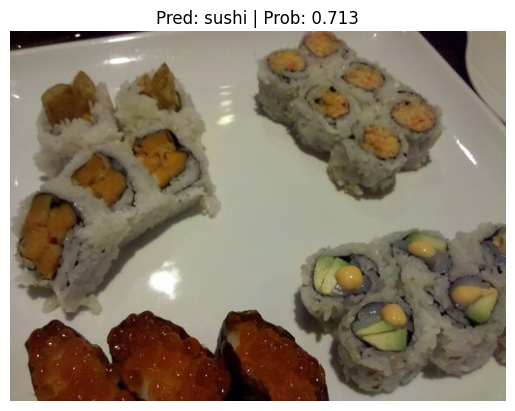

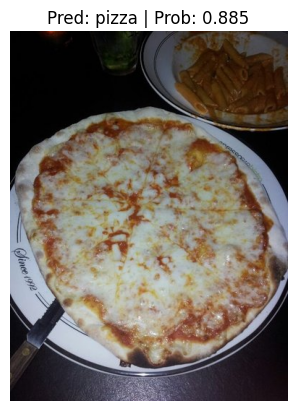

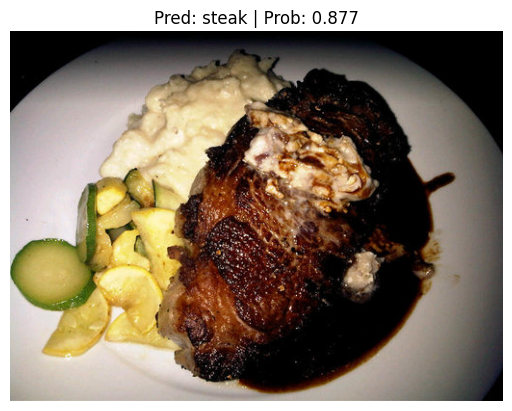

In [51]:
from modular_version.predictions import pred_and_plot_image

# Get a random list of 3 images from 20% test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(data_20_percent_path / "test").glob("*/*.jpg")) # get all test image paths from 20% dataset
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot) # randomly select k number of images

# Iterate through random test image paths, make predictions on them and plot them
for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))

### Predict on a custom image with the best model

data/04-pizza-dad.jpeg already exists, skipping download.


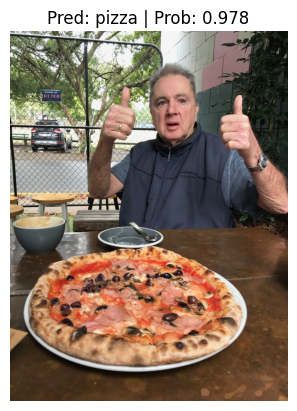

In [52]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = Path("data/04-pizza-dad.jpeg")

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)